# PCA over the 4 conditions and CCGP

## Data structure

This dataset contains neural recordings collected from monkeys P and S while they performed an arm reaching task under four different conditions: Control, HFS, FF, and FFHFS. The analyses were conducted separately for each monkey (P and S). During each recording session, one to four neurons were recorded while the monkey was reaching for the same target throughout the session. Although different targets were set for different sessions, we will disregard that information for the following analysis. 

## Pre-processing of the data

The spikes of activity were first convolved with a gaussian kernel of 100 ms for the low-dimension representation of the 4 conditions and the CCGP and 50 ms for the Null Field/FF discrimination.
Only neurons with at least 10 trials for P and 20 for S in all 4 conditions were kept and the data, consisting in a tensor of size ($\#neurons \times \#condition \times \#time bins$) was called $X$. We then selected a time window of size 300 ms for the low-dimensional representation and the CCGP, and 100 ms for the Null Field/FF discrimination task, and then z-scored the data over the condition dimension. $X_{\textrm{z-scored}} = \frac{X - <X>_\textrm{condition}}{\textrm{std}_\textrm{condition}(X)}$. A PCA was then performed on this z-scored data, the plot of the first 3 PCs is represented in the low-dimensional representation of the 4 conditions. 

## CCGP

The CCGP analysis developed by Fusi was performed on the $X_{\textrm{z-scored}}$ data using the LinearSVC python library.

## 4 conditions discrimination

For this analysis, only the 15 first PCs were kept. We define a test set by taking out half of the trials for each neuron and train a linear classifier thanks to the LinearSVC library to discriminate between Null Field and Force Field under both Control and HFS conditions. The variance of the accuracy resulted from the sampling of the trials. The same number of trials was taken for all conditions.

# Visualizing the the 4 conditions in a low dimensional subspace

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
from functions import *
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from scipy.spatial.distance import mahalanobis
from matplotlib.lines import Line2D

In [205]:
monkey = 'sophie'

for cond in ['cont1', 'hfs', 'ff', 'ff_hfs']:
    data_file = 'data_dics/'+ monkey + '_' + cond + '_go_validt_dic.npy'
    
    dic = get_data(data_file)
    dic = smoothen_data(dic, sigma = 100)
    #dic = smoothen_data_window_fct(dic, width=100)
    
        
    if cond == 'cont1':
        dic_cont1 = dic
    if cond == 'hfs':
        dic_hfs = dic
    if cond == 'ff':
        dic_ff = dic
    if cond == 'ff_hfs':
        dic_ff_hfs = dic

In [206]:
# set the minimum number of trials per neuron to consider for filtering
trials_thresh = 10

# get the number of neurons in the dataset
nb_neurons = len(dic_cont1['target'])

# initialize arrays to store the number of trials for each condition for each neuron
nb_trials_cont1 = np.zeros(nb_neurons)
nb_trials_hfs = np.zeros(nb_neurons)
nb_trials_ff = np.zeros(nb_neurons)
nb_trials_ffhfs = np.zeros(nb_neurons)

# loop through each neuron and record the number of trials for each condition
for neuron in range(nb_neurons):
    nb_trials_cont1[neuron] = dic_cont1['target'][neuron].shape[0]
    nb_trials_hfs[neuron] = dic_hfs['target'][neuron].shape[0]
    nb_trials_ff[neuron] = dic_ff['target'][neuron].shape[0]
    nb_trials_ffhfs[neuron] = dic_ff_hfs['target'][neuron].shape[0]

# create boolean arrays to filter neurons based on minimum number of trials for each condition
filter_cont1 = (nb_trials_cont1 > trials_thresh)
filter_hfs = (nb_trials_hfs > trials_thresh)
filter_ff = (nb_trials_ff > trials_thresh)
filter_ffhfs = (nb_trials_ffhfs > trials_thresh)

# apply a final filter to keep neurons that have sufficient number of trials for all conditions
neuron_filter = (filter_cont1 * filter_hfs * filter_ff * filter_ffhfs)


In [207]:
# Get the number of neurons and time frames in the data
nb_neurons = len(dic_cont1['target'])
nb_time_frames = dic_cont1['mat'][200].shape[1]

# Create empty arrays to store the data
data_all_cond_avg = np.zeros((nb_neurons, 4, nb_time_frames))
data_all = np.zeros((nb_neurons, 4 * trials_thresh, nb_time_frames))

# Initialize a counter variable
count = 0

# Loop through each neuron in the data
for neuron in range(nb_neurons):
    # Check if the neuron passes the filter
    if neuron_filter[neuron] == True:
        # Increment the counter
        count += 1
        
        # Loop through each condition and extract the data
        for cond, dic in enumerate([dic_cont1, dic_hfs, dic_ff, dic_ff_hfs]):
            # Calculate the average over all trials for the current condition
            data_all_cond_avg[neuron, cond, :] = dic['mat'][neuron].mean(axis=0)
            # Extract the first 'trials_thresh' trials for the current condition and store them in the 'data_all' array
            data_all[neuron, cond*trials_thresh: (cond+1)*trials_thresh] = dic['mat'][neuron][:trials_thresh]

# Print the number of neurons that passed the filter
print(count)


230


In [214]:
# Set values for t and window size
t = 2700
window_size = 300

# Create numpy arrays with zeros for storing z-scored data
data_all_zscored = np.zeros((nb_neurons, 4, nb_time_frames))
data_allt_zscored = np.zeros((nb_neurons, 4 * trials_thresh, nb_time_frames))

# Loop through each neuron
for neuron in range(nb_neurons):
    # Compute z-scored data for data_all_zscored
    data_all_zscored[neuron] = (data_all_cond_avg[neuron] - data_all_cond_avg[neuron, :, t:t+window_size].mean()) / (1e-04 + data_all_cond_avg[neuron,:,t:t+window_size].std())
    # Compute z-scored data for data_allt_zscored
    data_allt_zscored[neuron] = (data_all[neuron] - data_all_cond_avg[neuron, :, t:t+window_size].mean()) / (1e-04 + data_all_cond_avg[neuron,:,t:t+window_size].std())

# Create numpy arrays with zeros for storing z-scored data for different conditions
data_cont_zscored = np.zeros((nb_neurons, nb_time_frames))
data_hfs_zscored = np.zeros((nb_neurons, nb_time_frames))
data_ff_zscored = np.zeros((nb_neurons, nb_time_frames))
data_ffhfs_zscored = np.zeros((nb_neurons, nb_time_frames))

# Loop through each neuron
for neuron in range(nb_neurons):
    # Compute z-scored data for control condition
    data_cont_zscored[neuron] = (data_all_cond_avg[neuron,0] - data_all_cond_avg[neuron,0,t:t+window_size].mean()) / (1e-04 + data_all_cond_avg[neuron,0,t:t+window_size].std())
    # Compute z-scored data for high-frequency stimulation condition
    data_hfs_zscored[neuron] = (data_all_cond_avg[neuron,1] - data_all_cond_avg[neuron,1,t:t+window_size].mean()) / (1e-04 + data_all_cond_avg[neuron,1,t:t+window_size].std())
    # Compute z-scored data for force field stimulation condition
    data_ff_zscored[neuron] = (data_all_cond_avg[neuron,2] - data_all_cond_avg[neuron,2,t:t+window_size].mean()) / (1e-04 + data_all_cond_avg[neuron,2,t:t+window_size].std())
    # Compute z-scored data for force field and high-frequency stimulation condition
    data_ffhfs_zscored[neuron] = (data_all_cond_avg[neuron,3] - data_all_cond_avg[neuron,3,t:t+window_size].mean()) / (1e-04 + data_all_cond_avg[neuron,3,t:t+window_size].std())


In [215]:
nb_neur = neuron_filter.sum()

# Do a PCA on the data averaged over the trials
R = np.array(data_all_zscored)[neuron_filter,:,t:t+window_size].mean(axis=2)
X = R.reshape((nb_neur,4))
C = X @ X.transpose()     
eigvals, eigvects = np.linalg.eigh(C)[0], np.linalg.eigh(C)[1]


In [216]:
# store the projection of the neural data on these PCs in neur_states_allt
neur_states_allt = np.zeros((4*trials_thresh,t+window_size,3))

for i in range(4):
    for tr in range(trials_thresh):
        X_target = data_allt_zscored[neuron_filter, tr+i*trials_thresh, :t+window_size]
        k=0
        for dim in [1,2,3]:
            neur_states_allt[tr+i*trials_thresh,:,k] = -eigvects[:,-dim]@X_target
            k+=1
neur_states_allt.shape

(40, 3000, 3)

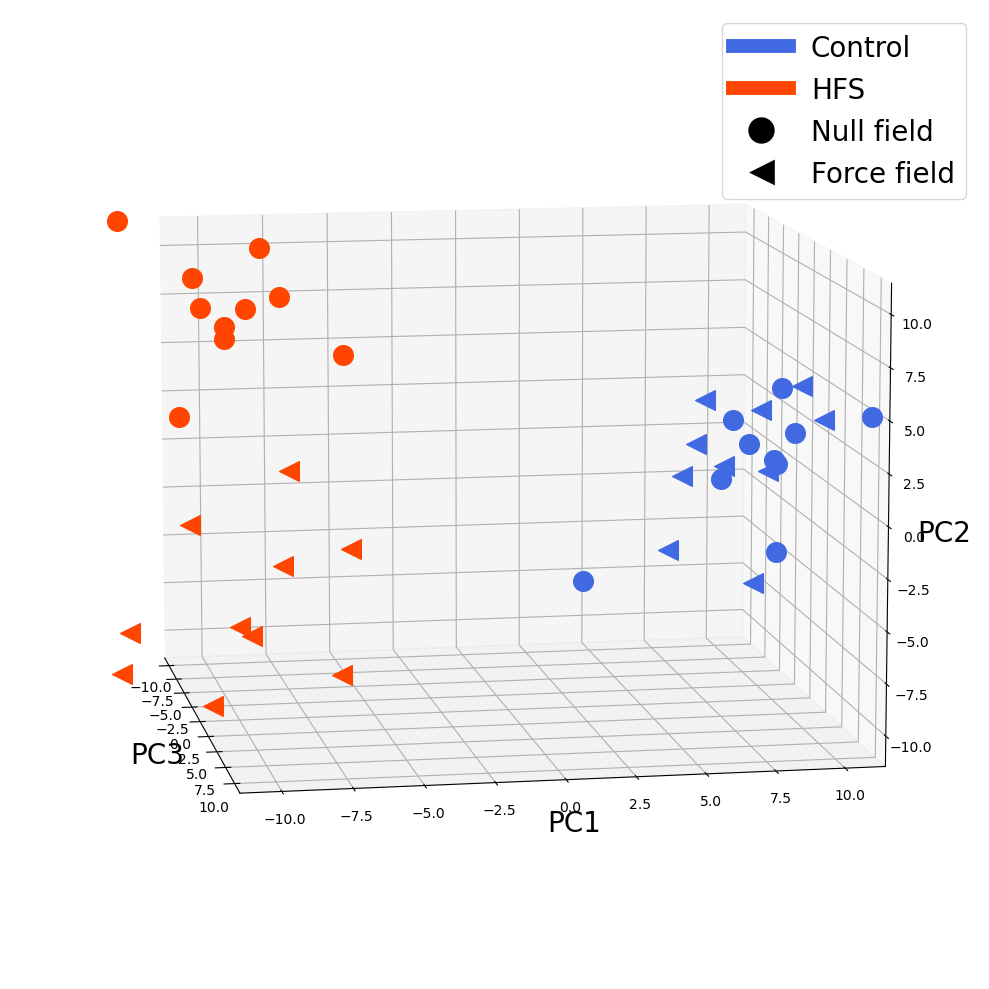

In [217]:
plt.rcParams["figure.autolayout"] = True

N = 50
fps = 120
frn = 10*fps


fig = plt.figure(figsize = (10,10))
colors = ['royalblue', 'orangered', 'royalblue', 'orangered']
lstyles = ['solid', 'solid',  (0, (5, 1)), (0, (5, 1))]
cond_list = ['Cont1', 'HFS', 'FF', 'FF-HFS']
markers = ['o', 'o', '<', '<']
angle = 30
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('PC1', size = 20)
ax.set_ylabel('PC2', size = 20)
ax.set_zlabel('PC3', size = 20)

ax.set_xlim3d(-11,11)
ax.set_ylim3d(-11,11)
ax.set_zlim3d(-11,11)

for i in [0,2,1,3]:
    tr = i*trials_thresh

    for k in range(trials_thresh):
        ax.scatter(neur_states_allt[tr+k,t:t+window_size,0].mean(axis=(0)), neur_states_allt[tr+k,t:t+window_size,1].mean(axis=(0)), -neur_states_allt[tr+k,t:t+window_size,2].mean(axis=(0)) , marker = markers[i], s = 200,  color=colors[i])
        

legend_elements = [Line2D([0], [0], lw=10, color='royalblue', label='Control'),
                   Line2D([0], [0], lw=10, color='orangered', label='HFS'),
                   Line2D([0], [0], marker='o', color='w',markerfacecolor='k', label='Null field',markersize=20),
                   Line2D([0], [0], marker='<', color='w', markerfacecolor='k',label='Force field',markersize=20)]
ax.legend(handles = legend_elements,fontsize = 20)
ax.view_init(20, angle, vertical_axis='y')
plot = 0

def change_plot(frame_number, plot=0):
    ax.view_init(10, 130 + frame_number * (360-140)/frn , vertical_axis='y' )

ani = animation.FuncAnimation(fig, change_plot, frn, fargs=(plot),interval = 1000 / fps)
ani.save('PCA_anim_after_go_learning_thru_trials_'+monkey+'_%sto%sms.mp4'%(t,t+window_size))

In [218]:
zpos_list = neur_states_allt[:,t:t+window_size,2].mean(axis=(1))
zpos_range = zpos_list.max() - zpos_list.min() 
alpha_list = 0.6 * (zpos_list-zpos_list.min())/zpos_range
alpha_list

array([0.15211643, 0.1568699 , 0.25254089, 0.13807943, 0.28472628,
       0.        , 0.16858175, 0.18488924, 0.19181793, 0.24527763,
       0.45162819, 0.6       , 0.51320814, 0.51802382, 0.38313572,
       0.36253098, 0.30137971, 0.46984323, 0.34184385, 0.40170829,
       0.37055811, 0.23959297, 0.40675038, 0.40017479, 0.42836807,
       0.44949376, 0.30762655, 0.44117174, 0.44405517, 0.41273923,
       0.37887383, 0.38944814, 0.23912116, 0.30757623, 0.34143646,
       0.17968168, 0.21869964, 0.23542233, 0.24616269, 0.24163264])

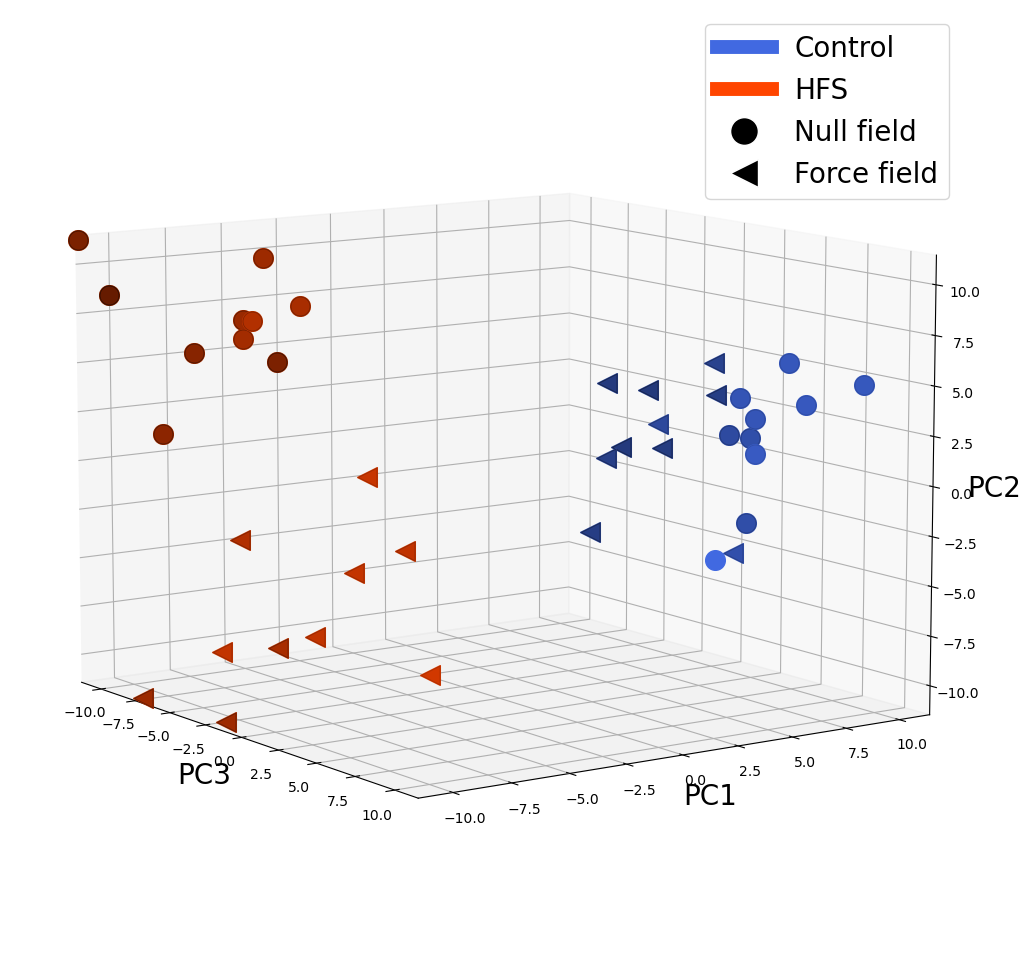

In [219]:
plt.rcParams["figure.autolayout"] = True

N = 50
fps = 120
frn = 10*fps


fig = plt.figure(figsize = (10,10))
colors = ['royalblue', 'orangered', 'royalblue', 'orangered']
lstyles = ['solid', 'solid',  (0, (5, 1)), (0, (5, 1))]
cond_list = ['Cont1', 'HFS', 'FF', 'FF-HFS']
markers = ['o', 'o', '<', '<']
angle = -35
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('PC1', size = 20)
ax.set_ylabel('PC2', size = 20)
ax.set_zlabel('PC3', size = 20)

ax.set_xlim3d(-11,11)
ax.set_ylim3d(-11,11)
ax.set_zlim3d(-11,11)

for i in [0,2,1,3]:
    tr = i*trials_thresh
    
    for k in range(trials_thresh):
        ax.scatter(neur_states_allt[tr+k,t:t+window_size,0].mean(axis=(0)), neur_states_allt[tr+k,t:t+window_size,1].mean(axis=(0)), -neur_states_allt[tr+k,t:t+window_size,2].mean(axis=(0)) , marker = markers[i], s = 200,  color=colors[i])
    # Have a dark gradient to reveal depth
    for k in range(trials_thresh):
        ax.scatter(neur_states_allt[tr+k,t:t+window_size,0].mean(axis=(0)), neur_states_allt[tr+k,t:t+window_size,1].mean(axis=(0)), -neur_states_allt[tr+k,t:t+window_size,2].mean(axis=(0)) , marker = markers[i], s = 200,  color='k', alpha = alpha_list[tr+k])
        

legend_elements = [Line2D([0], [0], lw=10, color='royalblue', label='Control'),
                   Line2D([0], [0], lw=10, color='orangered', label='HFS'),
                   Line2D([0], [0], marker='o', color='w',markerfacecolor='k', label='Null field',markersize=20),
                   Line2D([0], [0], marker='<', color='w', markerfacecolor='k',label='Force field',markersize=20)]
ax.legend(handles = legend_elements,fontsize = 20)
ax.view_init(10, angle, vertical_axis='y')

plt.savefig('PCA4'+monkey+'_snapshot_%sto%sms'%(t,t+window_size)+'.pdf', transparent=True, bbox_inches="tight")

# Quantifying how far away is Null-Field from FF under Control or HFS condition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
from functions import *
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from scipy.spatial.distance import mahalanobis
from sklearn.svm import LinearSVC
from itertools import *
from tqdm import tqdm
from matplotlib.lines import Line2D


In [2]:
monkey = 'penny'
trials_thresh = 10

# Loading the data

for cond in ['cont1', 'hfs', 'ff', 'ff_hfs']:
    data_file = 'data_dics/'+monkey+'_' + cond + '_go_validt_dic.npy'
    
    dic = get_data(data_file)
    dic = smoothen_data(dic, sigma = 50)
    #dic = smoothen_data_window_fct(dic, width=100)
    
        
    if cond == 'cont1':
        dic_cont1 = dic
    if cond == 'hfs':
        dic_hfs = dic
    if cond == 'ff':
        dic_ff = dic
    if cond == 'ff_hfs':
        dic_ff_hfs = dic

In [3]:
# Building a neuron filter to ensure a minimum number of trials per condition

nb_neurons = len(dic_cont1['target'])
nb_trials_cont1 = np.zeros(nb_neurons)
nb_trials_hfs = np.zeros(nb_neurons)
nb_trials_ff = np.zeros(nb_neurons)
nb_trials_ffhfs = np.zeros(nb_neurons)

for neuron in range(nb_neurons):
    nb_trials_cont1[neuron] = dic_cont1['target'][neuron].shape[0]
    nb_trials_hfs[neuron] = dic_hfs['target'][neuron].shape[0]
    nb_trials_ff[neuron] = dic_ff['target'][neuron].shape[0]
    nb_trials_ffhfs[neuron] = dic_ff_hfs['target'][neuron].shape[0]


filter_cont1 = (nb_trials_cont1 > trials_thresh)
filter_hfs = (nb_trials_hfs > trials_thresh)
filter_ff = (nb_trials_ff > trials_thresh)
filter_ffhfs = (nb_trials_ffhfs > trials_thresh)

neuron_filter = (filter_cont1 * filter_hfs * filter_ff * filter_ffhfs)

# Creating data_all and adata_all_conf_avg

nb_neurons = len(dic_cont1['target'])
nb_time_frames = dic_cont1['mat'][200].shape[1]

data_all_cond_avg = np.zeros((nb_neurons, 4, nb_time_frames))
data_all = np.zeros((nb_neurons, 4 * trials_thresh, nb_time_frames))

count = 0

for neuron in range(nb_neurons):
    if neuron_filter[neuron] == True:
        #if dic_ff['dir'][neuron][0] == 3:
        count+=1
        #print(dic_cont1['target'][neuron][0])
        for cond, dic in enumerate([dic_cont1, dic_hfs, dic_ff, dic_ff_hfs]):

            data_all_cond_avg[neuron, cond, :] = dic['mat'][neuron].mean(axis=0)
            data_all[neuron, cond*trials_thresh: (cond+1)*trials_thresh] = dic['mat'][neuron][:trials_thresh]
print(count)

94


In [4]:
def compute_data_zscored(t, window_size, trials_thresh, data_all_cond_avg, data_all):
    nb_neurons = len(data_all)
    nb_time_frames = data_all.shape[2]

    data_all_zscored = np.zeros((nb_neurons, 4, nb_time_frames))
    data_allt_zscored = np.zeros((nb_neurons, 4 * trials_thresh, nb_time_frames))

    for neuron in range(nb_neurons):
        data_all_zscored[neuron] = (data_all_cond_avg[neuron] - data_all_cond_avg[neuron, :, t-window_size//2:t+window_size//2].mean())/(1e-04+data_all_cond_avg[neuron,:,t-window_size//2:t+window_size//2].std())
        data_allt_zscored[neuron] = (data_all[neuron] - data_all_cond_avg[neuron, :, t-window_size//2:t+window_size//2].mean())/(1e-04+data_all_cond_avg[neuron,:,t-window_size//2:t+window_size//2].std())
    return data_all_zscored, data_allt_zscored

In [5]:
def get_classifying_acc(t, window_size, nb_pcs, nb_test_set_trials, nb_sample, data_all_cond_avg, data_all, trials_thresh):

    nb_train_set_trials = trials_thresh-nb_test_set_trials

    # get the z-scored data
    data_all_zscored, data_allt_zscored = compute_data_zscored(t, window_size, trials_thresh, data_all_cond_avg, data_all)

    ns = []
    y = []

    # make a PCA on the zscored data on the specific time window 
    nb_neur = neuron_filter.sum()
    R = np.array(data_all_zscored)[neuron_filter,:,t-window_size//2:t+window_size//2]
    X = R.reshape((nb_neur,window_size*4))
    C = X @ X.transpose()     
    eigvals, eigvects = np.linalg.eigh(C)[0], np.linalg.eigh(C)[1]

    
    #project the data on the first nb_pcs PCs and store it in Xdata
    for cond in range(4):
        Xdata = data_allt_zscored[neuron_filter,trials_thresh*cond:trials_thresh*(cond+1),t-window_size//2:t+window_size//2]
        ns.append( (Xdata.transpose()@eigvects[:,::-1][:,:nb_pcs]).transpose() )
        y.append(cond*np.ones((trials_thresh,window_size))) 

    ns = np.array(ns)
    y = np.array(y)


    acc_cont=[]
    acc_hfs = []

    cont_ind = [0,2]
    hfs_ind = [1,3]
    
    # train a linear decoder to differntiate between FF and Null Field under the control and HFS conditions

    for k in tqdm(range(nb_sample)):

        test_trials = np.random.choice(np.arange(trials_thresh), nb_test_set_trials, replace = False)
        tr_trials = np.delete(np.arange(trials_thresh), test_trials)

        ns_test = ns[:,:,test_trials,:]
        ns_train = ns[:,:,tr_trials,:]

        y_test = y[:,test_trials,:]
        y_train = y[:,tr_trials,:]

        clf_cont = LinearSVC(max_iter = 30000, C=0.1)
        clf_cont.fit(ns_train[cont_ind].swapaxes(1,0).reshape(nb_pcs, 2*nb_train_set_trials*window_size).transpose(), y_train[cont_ind].reshape((2*nb_train_set_trials*window_size)))
        clf_hfs = LinearSVC(max_iter = 30000, C=0.1)
        clf_hfs.fit(ns_train[hfs_ind].swapaxes(1,0).reshape(nb_pcs, 2*nb_train_set_trials*window_size).transpose(), y_train[hfs_ind].reshape((2*nb_train_set_trials*window_size)))

        acc_int_cont = []
        acc_int_hfs = []

        for j in range(nb_test_set_trials):
            acc_int_cont.append(clf_cont.predict(ns_test[cont_ind, :, j, :].swapaxes(1,0).reshape(nb_pcs,2*window_size).transpose())  == np.concatenate(y_test[cont_ind,j,:], axis = 0))
            acc_int_hfs.append(clf_hfs.predict(ns_test[hfs_ind, :, j, :].swapaxes(1,0).reshape(nb_pcs,2*window_size).transpose())  == np.concatenate(y_test[hfs_ind,j,:], axis = 0))
        acc_cont.append(acc_int_cont)
        acc_hfs.append(acc_int_hfs)
        
    return acc_cont, acc_hfs

In [6]:
# Choosing the parameters for conducting the classification of Null Field Vs. Force Field

times = [2500, 2700, 2950, 3200]
window_size = 100
nb_pcs = 15
nb_test_set_trials = 5 #10
nb_sample = 200

# Running this analysis both under the Control and HFS condition

acc_cont, acc_hfs = [],[]

for t in times:
    res_cont, res_hfs=get_classifying_acc(t, window_size, nb_pcs, nb_test_set_trials, nb_sample, data_all_cond_avg, data_all, trials_thresh)
    acc_cont.append(res_cont)
    acc_hfs.append(res_hfs)
acc_cont = np.array(acc_cont)
acc_hfs = np.array(acc_hfs)

100%|██████████| 200/200 [00:01<00:00, 173.27it/s]


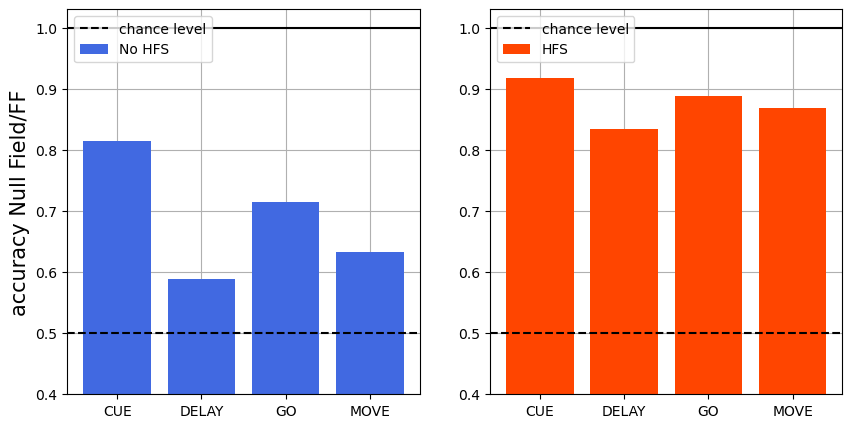

In [7]:
acc_cont_avg = acc_cont.mean(axis = (1,2,3))
acc_hfs_avg = acc_hfs.mean(axis = (1,2,3))
acc_cont_std = acc_cont.std(axis = (1,2,3))
acc_hfs_std = acc_hfs.std(axis = (1,2,3))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].bar(['CUE','DELAY','GO','MOVE'], acc_cont_avg, label = 'No HFS', color = 'royalblue')
ax[1].bar(['CUE','DELAY','GO','MOVE'], acc_hfs_avg, color = 'orangered', label = 'HFS')
ax[0].set_ylim(0.4, 1.03)
ax[1].set_ylim(0.4, 1.03)
ax[0].grid()
ax[1].grid()
#ax[0].set_xlabel('time (ms)', size = 15)
#ax[1].set_xlabel('time (ms)', size = 15)
ax[0].set_ylabel('accuracy Null Field/FF', size = 15)
#ax[1].set_ylabel('accuracy FF/NO FF', size = 15)

ax[0].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')
ax[1].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')

ax[0].axhline(y=1 , color = 'k', linestyle = '-')
ax[1].axhline(y=1 , color = 'k', linestyle = '-')

ax[0].legend(fontsize = 10, loc = 'upper left')
ax[1].legend(fontsize = 10, loc = 'upper left')

ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

#plt.savefig('accuracy_FF_NoFF_'+monkey+'.pdf', transparent=True, bbox_inches="tight")

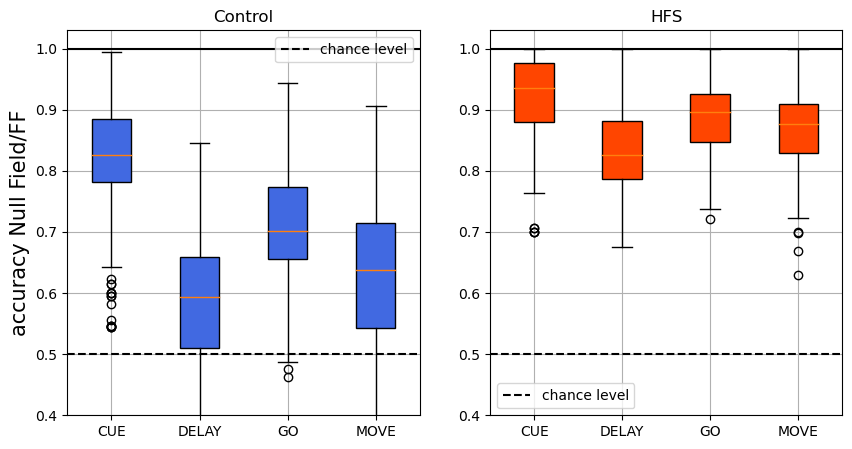

In [10]:
acc_cont_avg = acc_cont.mean(axis = (2,3))
acc_hfs_avg = acc_hfs.mean(axis = (2,3))
acc_cont_std = acc_cont.std(axis = (2,3))
acc_hfs_std = acc_hfs.std(axis = (2,3))

fig, ax = plt.subplots(1,2, figsize = (10,5))
labels = ['CUE','DELAY','GO','MOVE']

bplot_cont = ax[0].boxplot( [acc_cont_avg[0], acc_cont_avg[1], acc_cont_avg[2], acc_cont_avg[3]], labels=labels, patch_artist=True)
bplot_hfs = ax[1].boxplot( [acc_hfs_avg[0], acc_hfs_avg[1], acc_hfs_avg[2], acc_hfs_avg[3]], labels=labels, patch_artist=True)
ax[0].set_ylim(0.4, 1.03)
ax[1].set_ylim(0.4, 1.03)
ax[0].grid()
ax[1].grid()

ax[0].set_ylabel('accuracy Null Field/FF', size = 15)

for patch, color in zip(bplot_cont['boxes'], colors):
    patch.set_facecolor('royalblue')

for patch, color in zip(bplot_hfs['boxes'], colors):
    patch.set_facecolor('orangered')

ax[0].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')
ax[1].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')

ax[0].axhline(y=1 , color = 'k', linestyle = '-')
ax[1].axhline(y=1 , color = 'k', linestyle = '-')

ax[0].set_title('Control')
ax[1].set_title('HFS')

ax[0].legend(fontsize = 10)
ax[1].legend(fontsize = 10)

ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

#plt.savefig('accuracy_FF_NoFF_'+monkey+'boxplot.pdf', transparent=True, bbox_inches="tight")

# Same discrimination but on early/late sub-datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
from functions import *
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from scipy.spatial.distance import mahalanobis
from sklearn.svm import LinearSVC
from itertools import *
from tqdm import tqdm
from matplotlib.lines import Line2D


In [41]:
monkey = 'sophie'
trials_thresh = 20
trials_thresh_control = 10

# Loading the data

for cond in ['cont1', 'hfs', 'ff', 'ff_hfs']:
    data_file = 'data_dics/'+monkey+'_' + cond + '_go_validt_dic.npy'
    
    dic = get_data(data_file)
    dic = smoothen_data(dic, sigma = 50)
    #dic = smoothen_data_window_fct(dic, width=100)
    
        
    if cond == 'cont1':
        dic_cont1 = dic
    if cond == 'hfs':
        dic_hfs = dic
    if cond == 'ff':
        dic_ff = dic
    if cond == 'ff_hfs':
        dic_ff_hfs = dic

In [42]:
# Building a neuron filter to ensure a minimum number of trials per condition

nb_neurons = len(dic_cont1['target'])
nb_trials_cont1 = np.zeros(nb_neurons)
nb_trials_hfs = np.zeros(nb_neurons)
nb_trials_ff = np.zeros(nb_neurons)
nb_trials_ffhfs = np.zeros(nb_neurons)

for neuron in range(nb_neurons):
    nb_trials_cont1[neuron] = dic_cont1['target'][neuron].shape[0]
    nb_trials_hfs[neuron] = dic_hfs['target'][neuron].shape[0]
    nb_trials_ff[neuron] = dic_ff['target'][neuron].shape[0]
    nb_trials_ffhfs[neuron] = dic_ff_hfs['target'][neuron].shape[0]


filter_cont1 = (nb_trials_cont1 > trials_thresh_control)
filter_hfs = (nb_trials_hfs > trials_thresh_control)
filter_ff = (nb_trials_ff > trials_thresh)
filter_ffhfs = (nb_trials_ffhfs > trials_thresh)

neuron_filter = (filter_cont1 * filter_hfs * filter_ff * filter_ffhfs)

# Creating data_all and adata_all_conf_avg

nb_neurons = len(dic_cont1['target'])
nb_time_frames = dic_cont1['mat'][200].shape[1]

data_all_cond_avg = np.zeros((nb_neurons, 4, nb_time_frames))
data_all = np.zeros((nb_neurons, 2*trials_thresh_control + 2*trials_thresh, nb_time_frames))

count = 0

for neuron in range(nb_neurons):
    if neuron_filter[neuron] == True:
        #if dic_ff['dir'][neuron][0] == 3:
        count+=1
        #print(dic_cont1['target'][neuron][0])
        for cond, dic in enumerate([dic_cont1, dic_hfs]):

            data_all_cond_avg[neuron, cond, :] = dic['mat'][neuron].mean(axis=0)
            data_all[neuron, cond*trials_thresh_control: (cond+1)*trials_thresh_control] = dic['mat'][neuron][:trials_thresh_control]
            
            
        for cond, dic in enumerate([dic_ff, dic_ff_hfs]):

            data_all_cond_avg[neuron, cond, :] = dic['mat'][neuron].mean(axis=0)
            data_all[neuron, 2*trials_thresh_control+cond*trials_thresh: 2*trials_thresh_control+(cond+1)*trials_thresh] = dic['mat'][neuron][:trials_thresh]
print(count)

198


In [43]:
def compute_data_zscored(t, window_size, trials_thresh_control, trials_thresh, data_all_cond_avg, data_all):
    nb_neurons = len(data_all)
    nb_time_frames = data_all.shape[2]

    data_all_zscored = np.zeros((nb_neurons, 4, nb_time_frames))
    data_allt_zscored = np.zeros((nb_neurons, 2*trials_thresh_control + 2*trials_thresh, nb_time_frames))

    for neuron in range(nb_neurons):
        data_all_zscored[neuron] = (data_all_cond_avg[neuron] - data_all_cond_avg[neuron, :, t-window_size//2:t+window_size//2].mean())/(1e-04+data_all_cond_avg[neuron,:,t-window_size//2:t+window_size//2].std())
        data_allt_zscored[neuron] = (data_all[neuron] - data_all_cond_avg[neuron, :, t-window_size//2:t+window_size//2].mean())/(1e-04+data_all_cond_avg[neuron,:,t-window_size//2:t+window_size//2].std())
    return data_all_zscored, data_allt_zscored

In [44]:
data_all_zscored, data_allt_zscored = compute_data_zscored(2500, 100, trials_thresh_control, trials_thresh, data_all_cond_avg, data_all)

In [45]:
data_allt_zscored.shape

(392, 60, 6001)

In [46]:
def get_classifying_acc_earlyVSlate(t, window_size, nb_pcs, nb_test_set_trials, nb_sample, data_all_cond_avg, data_all, trials_thresh_control, trials_thresh, nb_trials_to_consier, early = True):
     # nb_trials_to_consider : number of trials from which we sample (starting from the end if early = False and from the beginning if early = True)
    nb_train_set_trials = nb_trials_to_consider-nb_test_set_trials

    # get the z-scored data
    data_all_zscored, data_allt_zscored = compute_data_zscored(t, window_size, trials_thresh_control, trials_thresh, data_all_cond_avg, data_all)

    ns = []
    y = []

    # make a PCA on the zscored data on the specific time window 
    nb_neur = neuron_filter.sum()
    R = np.array(data_all_zscored)[neuron_filter,:,t-window_size//2:t+window_size//2]
    X = R.reshape((nb_neur,window_size*4))
    C = X @ X.transpose()     
    eigvals, eigvects = np.linalg.eigh(C)[0], np.linalg.eigh(C)[1]


    #project the data on the first nb_pcs PCs and store it in Xdata
    for cond, dic in enumerate([dic_cont1, dic_hfs]):

        Xdata = data_allt_zscored[neuron_filter,trials_thresh_control*cond:trials_thresh_control*(cond+1),t-window_size//2:t+window_size//2]
        ns.append( (Xdata.transpose()@eigvects[:,::-1][:,:nb_pcs]).transpose() )
        y.append(cond*np.ones((trials_thresh_control,window_size))) 

    for cond, dic in enumerate([dic_ff, dic_ff_hfs]):

        Xdata = data_allt_zscored[neuron_filter, 2*trials_thresh_control+trials_thresh*cond: 2*trials_thresh_control+trials_thresh*(cond+1),t-window_size//2:t+window_size//2]
        ns.append( (Xdata.transpose()@eigvects[:,::-1][:,:nb_pcs]).transpose() )
        y.append((2+cond)*np.ones((trials_thresh,window_size))) 


    acc_cont=[]
    acc_hfs = []

    cont_ind = [0,2]
    hfs_ind = [1,3]

    # train a linear decoder to differntiate between FF and Null Field under the control and HFS conditions

    for k in tqdm(range(nb_sample)):

        test_trials = np.random.choice(np.arange(nb_trials_to_consider), nb_test_set_trials, replace = False)
        tr_trials = np.delete(np.arange(nb_trials_to_consider), test_trials)


        if early == False:
            test_trials = -test_trials-1
            tr_trials = -tr_trials-1

        ns_test = []
        ns_train = []
        y_test = []
        y_train = []

        for cond, dic in enumerate([dic_cont1, dic_hfs, dic_ff, dic_ff_hfs]):
            ns_test.append(ns[cond][:,test_trials,:])
            ns_train.append(ns[cond][:,tr_trials,:])

            y_test.append(y[cond][test_trials,:])
            y_train.append(y[cond][tr_trials,:])

        ns_test = np.array(ns_test)
        ns_train = np.array(ns_train)
        y_test = np.array(y_test)
        y_train = np.array(y_train)

        clf_cont = LinearSVC(max_iter = 30000, C=0.1)
        clf_cont.fit(ns_train[cont_ind].swapaxes(1,0).reshape(nb_pcs, 2*nb_train_set_trials*window_size).transpose(), y_train[cont_ind].reshape((2*nb_train_set_trials*window_size)))
        clf_hfs = LinearSVC(max_iter = 30000, C=0.1)
        clf_hfs.fit(ns_train[hfs_ind].swapaxes(1,0).reshape(nb_pcs, 2*nb_train_set_trials*window_size).transpose(), y_train[hfs_ind].reshape((2*nb_train_set_trials*window_size)))

        acc_int_cont = []
        acc_int_hfs = []

        for j in range(nb_test_set_trials):
            acc_int_cont.append(clf_cont.predict(ns_test[cont_ind, :, j, :].swapaxes(1,0).reshape(nb_pcs,2*window_size).transpose())  == np.concatenate(y_test[cont_ind,j,:], axis = 0))
            acc_int_hfs.append(clf_hfs.predict(ns_test[hfs_ind, :, j, :].swapaxes(1,0).reshape(nb_pcs,2*window_size).transpose())  == np.concatenate(y_test[hfs_ind,j,:], axis = 0))
        acc_cont.append(acc_int_cont)
        acc_hfs.append(acc_int_hfs)
        
    return acc_cont, acc_hfs

In [53]:
# Choosing the parameters for conducting the classification of Null Field Vs. Force Field

times = [2500, 2700, 2950, 3200]
window_size = 100
nb_pcs = 15
nb_test_set_trials = 5 #10
nb_sample = 200

nb_trials_to_consider = 10
early = False

# Running this analysis both under the Control and HFS condition

acc_cont, acc_hfs = [],[]

for t in times:
    res_cont, res_hfs=get_classifying_acc_earlyVSlate(t, window_size, nb_pcs, nb_test_set_trials, nb_sample, data_all_cond_avg, data_all, trials_thresh_control, trials_thresh, nb_trials_to_consider, early)
    acc_cont.append(res_cont)
    acc_hfs.append(res_hfs)
acc_cont = np.array(acc_cont)
acc_hfs = np.array(acc_hfs)

100%|██████████| 200/200 [00:03<00:00, 62.79it/s]


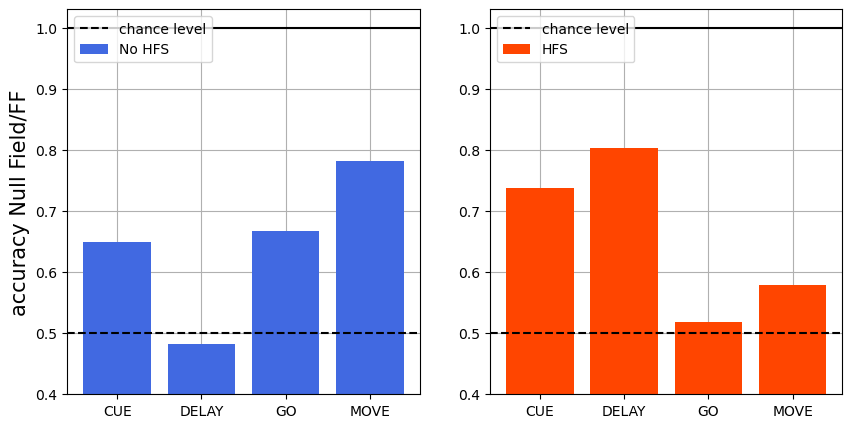

In [55]:
acc_cont_avg = acc_cont.mean(axis = (1,2,3))
acc_hfs_avg = acc_hfs.mean(axis = (1,2,3))
acc_cont_std = acc_cont.std(axis = (1,2,3))
acc_hfs_std = acc_hfs.std(axis = (1,2,3))
plt.rcParams['svg.fonttype'] = 'none'


fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].bar(['CUE','DELAY','GO','MOVE'], acc_cont_avg, label = 'No HFS', color = 'royalblue')
ax[1].bar(['CUE','DELAY','GO','MOVE'], acc_hfs_avg, color = 'orangered', label = 'HFS')
ax[0].set_ylim(0.4, 1.03)
ax[1].set_ylim(0.4, 1.03)
ax[0].grid()
ax[1].grid()
#ax[0].set_xlabel('time (ms)', size = 15)
#ax[1].set_xlabel('time (ms)', size = 15)
ax[0].set_ylabel('accuracy Null Field/FF', size = 15)
#ax[1].set_ylabel('accuracy FF/NO FF', size = 15)

ax[0].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')
ax[1].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')

ax[0].axhline(y=1 , color = 'k', linestyle = '-')
ax[1].axhline(y=1 , color = 'k', linestyle = '-')

ax[0].legend(fontsize = 10, loc = 'upper left')
ax[1].legend(fontsize = 10, loc = 'upper left')

ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

#plt.savefig('late10_accuracy_FF_NoFF_'+monkey+'.svg', transparent=True, bbox_inches="tight")

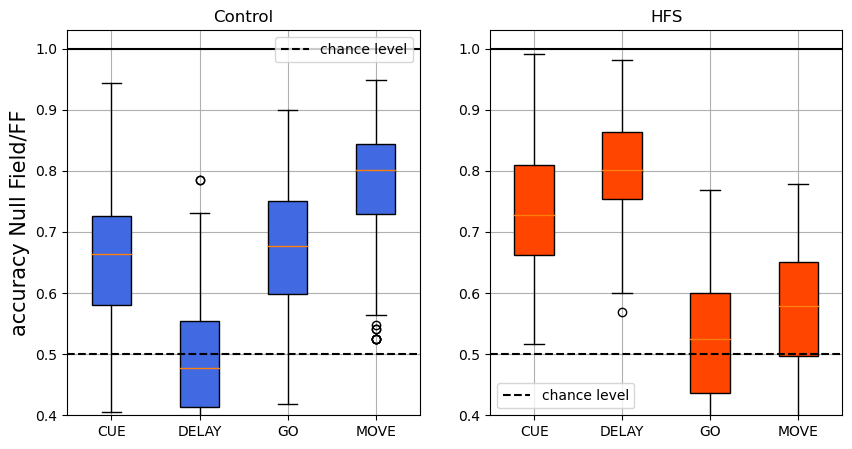

In [57]:
acc_cont_avg = acc_cont.mean(axis = (2,3))
acc_hfs_avg = acc_hfs.mean(axis = (2,3))
acc_cont_std = acc_cont.std(axis = (2,3))
acc_hfs_std = acc_hfs.std(axis = (2,3))
plt.rcParams['svg.fonttype'] = 'none'


fig, ax = plt.subplots(1,2, figsize = (10,5))
labels = ['CUE','DELAY','GO','MOVE']

bplot_cont = ax[0].boxplot( [acc_cont_avg[0], acc_cont_avg[1], acc_cont_avg[2], acc_cont_avg[3]], labels=labels, patch_artist=True)
bplot_hfs = ax[1].boxplot( [acc_hfs_avg[0], acc_hfs_avg[1], acc_hfs_avg[2], acc_hfs_avg[3]], labels=labels, patch_artist=True)
ax[0].set_ylim(0.4, 1.03)
ax[1].set_ylim(0.4, 1.03)
ax[0].grid()
ax[1].grid()

ax[0].set_ylabel('accuracy Null Field/FF', size = 15)

for patch, color in zip(bplot_cont['boxes'], colors):
    patch.set_facecolor('royalblue')

for patch, color in zip(bplot_hfs['boxes'], colors):
    patch.set_facecolor('orangered')

ax[0].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')
ax[1].axhline(y=0.5 , color = 'k', linestyle = '--', label = 'chance level')

ax[0].axhline(y=1 , color = 'k', linestyle = '-')
ax[1].axhline(y=1 , color = 'k', linestyle = '-')

ax[0].set_title('Control')
ax[1].set_title('HFS')

ax[0].legend(fontsize = 10)
ax[1].legend(fontsize = 10)

ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

#plt.savefig('late10_accuracy_FF_NoFF_'+monkey+'boxplot.pdf', transparent=True, bbox_inches="tight")

In [11]:
colors = ['forestgreen', 'forestgreen', 'slateblue', 'slateblue']

# Adapting Fusi's analysis to our data - CCGP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
from functions import *
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from scipy.spatial.distance import mahalanobis
from sklearn.svm import LinearSVC
from itertools import *
from tqdm import tqdm
from matplotlib.lines import Line2D


In [16]:
monkey = 'Sophie'

# Loading the data

for cond in ['cont1', 'hfs', 'ff', 'ff_hfs']:
    data_file = 'data_dics/'+monkey+'_' + cond + '_go_validt_dic.npy'
    
    dic = get_data(data_file)
    dic = smoothen_data(dic, sigma = 100)
    #dic = smoothen_data_window_fct(dic, width=100)
    
        
    if cond == 'cont1':
        dic_cont1 = dic
    if cond == 'hfs':
        dic_hfs = dic
    if cond == 'ff':
        dic_ff = dic
    if cond == 'ff_hfs':
        dic_ff_hfs = dic

In [ ]:
# set the minimum number of trials per neuron to consider for filtering
trials_thresh = 20

# get the number of neurons in the dataset
nb_neurons = len(dic_cont1['target'])

# initialize arrays to store the number of trials for each condition for each neuron
nb_trials_cont1 = np.zeros(nb_neurons)
nb_trials_hfs = np.zeros(nb_neurons)
nb_trials_ff = np.zeros(nb_neurons)
nb_trials_ffhfs = np.zeros(nb_neurons)

# loop through each neuron and record the number of trials for each condition
for neuron in range(nb_neurons):
    nb_trials_cont1[neuron] = dic_cont1['target'][neuron].shape[0]
    nb_trials_hfs[neuron] = dic_hfs['target'][neuron].shape[0]
    nb_trials_ff[neuron] = dic_ff['target'][neuron].shape[0]
    nb_trials_ffhfs[neuron] = dic_ff_hfs['target'][neuron].shape[0]

# create boolean arrays to filter neurons based on minimum number of trials for each condition
filter_cont1 = (nb_trials_cont1 > trials_thresh)
filter_hfs = (nb_trials_hfs > trials_thresh)
filter_ff = (nb_trials_ff > trials_thresh)
filter_ffhfs = (nb_trials_ffhfs > trials_thresh)

# apply a final filter to keep neurons that have sufficient number of trials for all conditions
neuron_filter = (filter_cont1 * filter_hfs * filter_ff * filter_ffhfs)


In [ ]:
# Get the number of neurons and time frames in the data
nb_neurons = len(dic_cont1['target'])
nb_time_frames = dic_cont1['mat'][200].shape[1]

# Create empty arrays to store the data
data_all_cond_avg = np.zeros((nb_neurons, 4, nb_time_frames))
data_all = np.zeros((nb_neurons, 4 * trials_thresh, nb_time_frames))

# Initialize a counter variable
count = 0

# Loop through each neuron in the data
for neuron in range(nb_neurons):
    # Check if the neuron passes the filter
    if neuron_filter[neuron] == True:
        # Increment the counter
        count += 1
        
        # Loop through each condition and extract the data
        for cond, dic in enumerate([dic_cont1, dic_hfs, dic_ff, dic_ff_hfs]):
            # Calculate the average over all trials for the current condition
            data_all_cond_avg[neuron, cond, :] = dic['mat'][neuron].mean(axis=0)
            # Extract the first 'trials_thresh' trials for the current condition and store them in the 'data_all' array
            data_all[neuron, cond*trials_thresh: (cond+1)*trials_thresh] = dic['mat'][neuron][:trials_thresh]

# Print the number of neurons that passed the filter
print(count)


In [20]:
def compute_data_zscored(t, window_size, trials_thresh, data_all_cond_avg, data_all):
    nb_neurons = len(data_all)
    nb_time_frames = data_all.shape[2]

    data_all_zscored = np.zeros((nb_neurons, 4, nb_time_frames))
    data_allt_zscored = np.zeros((nb_neurons, 4 * trials_thresh, nb_time_frames))

    for neuron in range(nb_neurons):
        data_all_zscored[neuron] = (data_all_cond_avg[neuron] - data_all_cond_avg[neuron, :, t-window_size//2:t+window_size//2].mean())/(1e-04+data_all_cond_avg[neuron,:,t-window_size//2:t+window_size//2].std())
        data_allt_zscored[neuron] = (data_all[neuron] - data_all_cond_avg[neuron, :, t-window_size//2:t+window_size//2].mean())/(1e-04+data_all_cond_avg[neuron,:,t-window_size//2:t+window_size//2].std())
    return data_all_zscored, data_allt_zscored


t = 2900
window_size = 100


data_all_zscored, data_allt_zscored = compute_data_zscored(t, window_size, trials_thresh, data_all_cond_avg, data_all)
    
data_cont_zscored = np.zeros((nb_neurons, nb_time_frames))
data_hfs_zscored = np.zeros((nb_neurons, nb_time_frames))
data_ff_zscored = np.zeros((nb_neurons, nb_time_frames))
data_ffhfs_zscored = np.zeros((nb_neurons, nb_time_frames))

for neuron in range(nb_neurons):
    data_cont_zscored[neuron] = (data_all_cond_avg[neuron,0] - data_all_cond_avg[neuron,0,t-window_size//2:t+window_size//2].mean())/(1e-04 + data_all_cond_avg[neuron,0,t:t+window_size].std())
    data_hfs_zscored[neuron] = (data_all_cond_avg[neuron,1] - data_all_cond_avg[neuron,1,t-window_size//2:t+window_size//2].mean())/(1e-04 + data_all_cond_avg[neuron,1,t:t+window_size].std())
    data_ff_zscored[neuron] = (data_all_cond_avg[neuron,2] - data_all_cond_avg[neuron,2,t-window_size//2:t+window_size//2].mean())/(1e-04 + data_all_cond_avg[neuron,2,t:t+window_size].std())
    data_ffhfs_zscored[neuron] = (data_all_cond_avg[neuron,3] - data_all_cond_avg[neuron,3,t-window_size//2:t+window_size//2].mean())/(1e-04 + data_all_cond_avg[neuron,3,t:t+window_size].std())


In [21]:
def get_classifying_acc_ccgp(t, trials_thresh, data_all_cond_avg, data_all, window_size = 300):
    
    data_all_zscored, data_allt_zscored = compute_data_zscored(t, window_size, trials_thresh, data_all_cond_avg, data_all)
    
    ns = []
    y = []
    N = neuron_filter.sum()
    for cond in range(4):
        ns.append(data_allt_zscored[neuron_filter,trials_thresh*cond:trials_thresh*(cond+1),t-window_size//2:t+window_size//2])
        y.append(cond*np.ones((trials_thresh,window_size)))

    ns = np.array(ns)
    y = np.array(y)

    acc = []

    for i in combinations(range(4), 2):
        tr_inds = np.array(i)
        test_inds = np.arange(4)[[k not in tr_inds for k in range(4)]]
        clf = LinearSVC(max_iter = 30000, C=0.1)
        clf.fit(ns[tr_inds].swapaxes(1,0).reshape(N, 2*trials_thresh*window_size).transpose(), y[tr_inds].reshape((2*trials_thresh*window_size)))
        acc_int = []
        for j in range(trials_thresh):
            acc_int.append(clf.predict(ns[test_inds, :, j, :].swapaxes(1,0).reshape(N,2*window_size).transpose())  == np.concatenate(y[tr_inds,j,:], axis = 0))
        acc.append(acc_int)
    return np.array(acc)

res = get_classifying_acc_ccgp( t, trials_thresh, data_all_cond_avg, data_all, window_size = 100)
res.shape

(6, 20, 200)

In [22]:
acc = []
for i,t in tqdm(enumerate(range(2000,4000,50))):
    acc.append(get_classifying_acc_ccgp( t, trials_thresh, data_all_cond_avg, data_all, window_size = 300))
acc = np.array(acc)

40it [01:17,  1.93s/it]


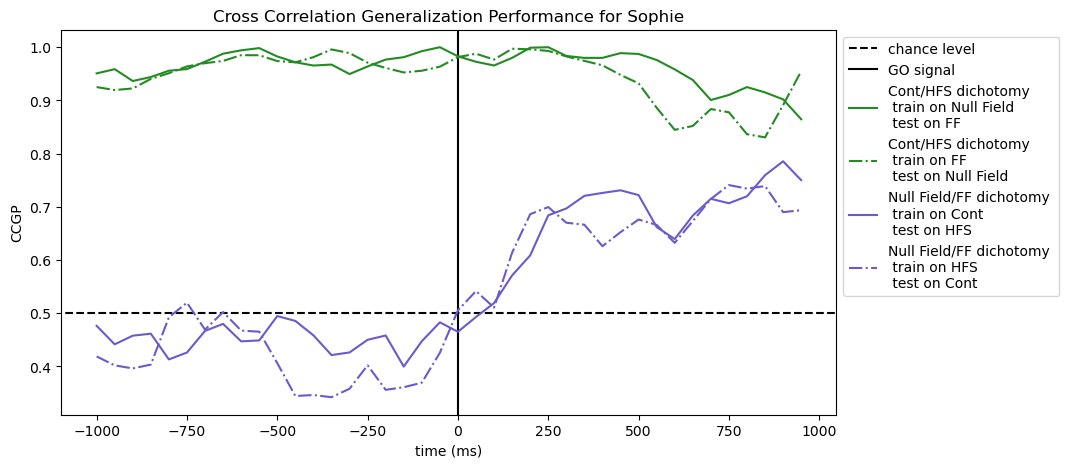

In [23]:
plt.figure(figsize = (10,5))

centering = 'GO'
plt.axhline(0.5, -1000,1000, c='k', linestyle = '--', label = 'chance level')
plt.axvline(0, -1,10, c='k', label=centering + ' signal')


colors = ['forestgreen', 'forestgreen', 'slateblue', 'slateblue']
linestyles = ['-', '-.', '-', '-.']
labels = ['Cont/HFS dichotomy \n train on Null Field\n test on FF', 'Cont/HFS dichotomy \n train on FF\n test on Null Field',
          'Null Field/FF dichotomy \n train on Cont\n test on HFS', 'Null Field/FF dichotomy \n train on HFS\n test on Cont']


for j,i in enumerate([0,5,1,4]):
    plt.plot(np.arange(2000,4000,50)-3000, acc[:,i,:,:].mean(axis=(1,2)), color = colors[j], linestyle = linestyles[j], label = labels[j])

    
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('time (ms)')
plt.ylabel('CCGP')
plt.title('Cross Correlation Generalization Performance for '+monkey)

plt.savefig('CCGP'+monkey+'.pdf', transparent=True, bbox_inches="tight")

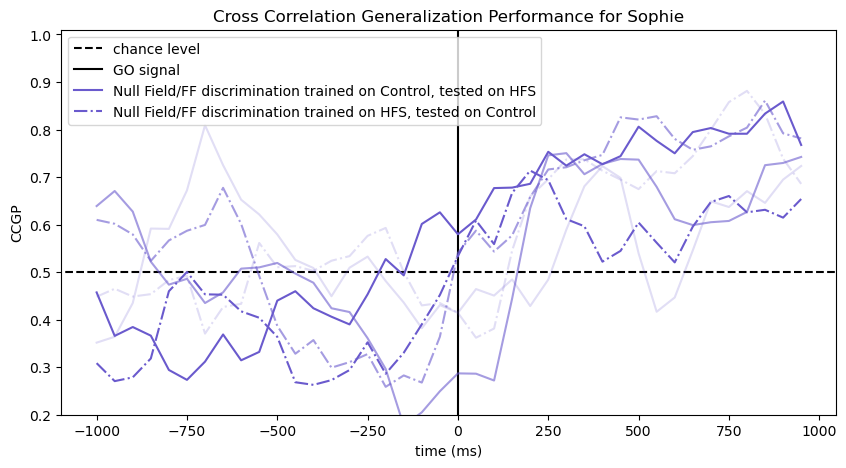

In [24]:
plt.figure(figsize = (10,5))

centering = 'GO'
plt.axhline(0.5, -1000,1000, c='k', linestyle = '--', label = 'chance level')
plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.ylim(0.2, 1.01)

xt = np.arange(-1000,1000,50)

plt.plot(xt, acc[:,1,0:5,:].mean(axis=(1,2)), color = 'slateblue', alpha = 0.2)
plt.plot(xt, acc[:,1,5:10,:].mean(axis=(1,2)), color = 'slateblue', alpha = 0.6)
plt.plot(xt, acc[:,1,10:,:].mean(axis=(1,2)), color = 'slateblue', alpha = 1, label = 'Null Field/FF discrimination trained on Control, tested on HFS')

plt.plot(xt, acc[:,4,0:5,:].mean(axis=(1,2)), color = 'slateblue', alpha = 0.2, linestyle ='-.')
plt.plot(xt, acc[:,4,5:10,:].mean(axis=(1,2)), color = 'slateblue', alpha = 0.6, linestyle ='-.')
plt.plot(xt, acc[:,4,10:,:].mean(axis=(1,2)), color = 'slateblue', alpha = 1, label = 'Null Field/FF discrimination trained on HFS, tested on Control', linestyle ='-.')

plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('CCGP')
plt.title('Cross Correlation Generalization Performance for '+monkey)

plt.savefig('CCGP_learning'+monkey+'.pdf', transparent=True, bbox_inches="tight")

In [25]:
for i in combinations(range(4), 2):
    tr_inds = np.array(i)
    test_inds = np.arange(4)[[k not in tr_inds for k in range(4)]]
    print(tr_inds, test_inds)

[0 1] [2 3]
[0 2] [1 3]
[0 3] [1 2]
[1 2] [0 3]
[1 3] [0 2]
[2 3] [0 1]


## Same plot but with a selected time window

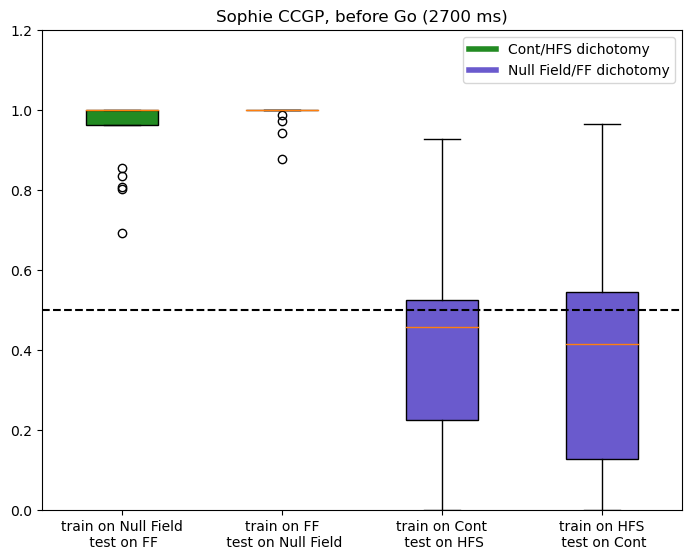

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(2)
times = [(2700-2000)//50, (3500-2000)//50]
colors = ['forestgreen', 'forestgreen', 'slateblue', 'slateblue']
labels = ['train on Null Field\n test on FF', 'train on FF\n test on Null Field', 'train on Cont\n test on HFS', 'train on HFS\n test on Cont']


bplot = ax.boxplot([acc[times[0],0,:,:].mean(axis=1) , acc[times[0],5,:,:].mean(axis=1), acc[times[0],1,:,:].mean(axis=1),  acc[times[0],4,:,:].mean(axis=1)], labels = labels, patch_artist=True)


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

cl = ax.hlines(y=0.5, xmin=0.5, xmax=4.5, color='k', linestyle='--', label = 'chance level')
ax.set_ylim(0, 1.2)

custom_lines = [Line2D([0], [0], color='forestgreen', lw=4),
                Line2D([0], [0], color='slateblue', lw=4)]
ax.legend(custom_lines, ['Cont/HFS dichotomy', 'Null Field/FF dichotomy'])

ax.set_title('Sophie CCGP, before Go (%s ms)'%(times[0]*50+2000))
plt.savefig('CCGP'+monkey+'beforeGO.pdf', transparent=True, bbox_inches="tight")

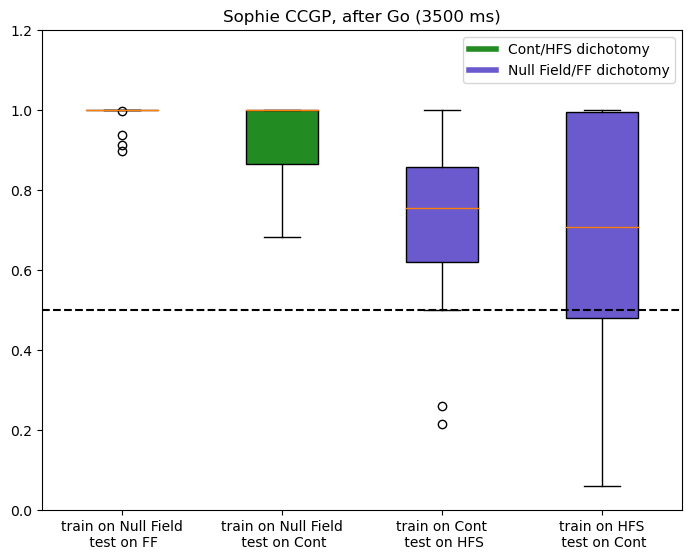

In [27]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(2)
times = [(2700-2000)//50, (3500-2000)//50]
colors = ['forestgreen', 'forestgreen', 'slateblue', 'slateblue']
labels = ['train on Null Field\n test on FF', 'train on Null Field\n test on Cont', 'train on Cont\n test on HFS', 'train on HFS\n test on Cont']


bplot = ax.boxplot([acc[times[1],0,:,:].mean(axis=1) , acc[times[1],5,:,:].mean(axis=1), acc[times[1],1,:,:].mean(axis=1),  acc[times[1],4,:,:].mean(axis=1)], labels = labels, patch_artist=True)


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

cl = ax.hlines(y=0.5, xmin=0.5, xmax=4.5, color='k', linestyle='--', label = 'chance level')
ax.set_ylim(0, 1.2)

custom_lines = [Line2D([0], [0], color='forestgreen', lw=4),
                Line2D([0], [0], color='slateblue', lw=4)]
ax.legend(custom_lines, ['Cont/HFS dichotomy', 'Null Field/FF dichotomy'])
ax.set_title('Sophie CCGP, after Go (%s ms)'%(times[1]*50+2000))
plt.savefig('CCGP'+monkey+'afterGO.pdf', transparent=True, bbox_inches="tight")